In [724]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch import nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import functools as Fntl
from functools import reduce
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

### pre-process for successful predictor

In [628]:
df1 = pd.read_csv("data/from_book/hour.csv")

In [629]:
df1

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [631]:
df1.shape

(17379, 17)

check the 1-hot / binary input features

In [632]:
pd.unique(df1['season'])

array([1, 2, 3, 4])

In [633]:
pd.unique(df1['yr'])

array([0, 1])

In [634]:
pd.unique(df1['mnth'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [635]:
pd.unique(df1['hr'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [636]:
pd.unique(df1['holiday'])

array([0, 1])

binary, ok

In [637]:
pd.unique(df1['weekday'])

array([6, 0, 1, 2, 3, 4, 5])

In [638]:
pd.unique(df1['workingday'])

array([0, 1])

binary, ok

In [639]:
pd.unique(df1['weathersit'])

array([1, 2, 3, 4])

transform those features into 1-hot

In [641]:
dummy_fields = ['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']
dummy_fields

['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']

In [648]:
df_proc = pd.DataFrame()
df_proc.shape

(0, 0)

In [650]:
pd.concat([df_proc, df1],axis=1)
df_proc.shape

(0, 0)

In [662]:
df_proc = Fntl.reduce(lambda acc, x: pd.concat([acc, pd.get_dummies(df1[x],prefix=x,drop_first=False)],axis=1),
                      dummy_fields,
                      pd.DataFrame())

In [663]:
df_proc.columns

Index(['season_1', 'season_2', 'season_3', 'season_4', 'yr_0', 'yr_1',
       'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1',
       'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10',
       'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18',
       'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [664]:
df_proc.shape

(17379, 53)

normalize qualitative input features

In [665]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed']

In [668]:
feature_statistics = {}
for k in quant_features:
    mean, std = (df1[k].mean(), df1[k].std())
    feature_statistics[k] = (mean, std)
    df_proc[k] = (df1[k] - mean) / std

In [669]:
df_proc

,season_1,season_2,season_3,season_4,yr_0,yr_1,mnth_1,mnth_2,mnth_3,mnth_4,...,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4,cnt,temp,hum,windspeed
0,1,0,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,-0.956312,-1.334609,0.947345,-1.553844
1,1,0,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,-0.823998,-1.438475,0.895513,-1.553844
2,1,0,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,-0.868103,-1.438475,0.895513,-1.553844
3,1,0,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,-0.972851,-1.334609,0.636351,-1.553844
4,1,0,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,-1.039008,-1.334609,0.636351,-1.553844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,-0.388467,-1.230743,-0.141133,-0.211685
17375,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,-0.553859,-1.230743,-0.141133,-0.211685
17376,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,-0.548346,-1.230743,-0.141133,-0.211685
17377,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,-0.708224,-1.230743,-0.348463,-0.456086


In [672]:
df_proc.shape

(17379, 57)

separate the target data.

In [673]:
target_fields = ['cnt', 'casual', 'registered']

In [675]:
df_tgts = df1[target_fields]
df_tgts

,cnt,casual,registered
0,16,3,13
1,40,8,32
2,32,5,27
3,13,3,10
4,1,0,1
...,...,...,...
17374,119,11,108
17375,89,8,81
17376,90,7,83
17377,61,13,48


separate train / test data & transform as tensors

In [676]:
df_inp_train = df_proc[:-21*24]
df_inp_test = df_proc[-21*24:]

In [677]:
df_inp_train.shape

(16875, 57)

In [678]:
df_inp_test.shape

(504, 57)

In [679]:
df_tgts_train, df_tgts_test = df_tgts[:-21*24], df_tgts[-21*24:]

In [680]:
df_tgts_train.shape

(16875, 3)

In [681]:
df_tgts_test.shape

(504, 3)

In [767]:
train_x = torch.tensor(df_inp_train.values).float()

In [845]:
train_y_v = df_tgts_train['cnt'].values
train_y = torch.tensor(train_y_v.reshape(len(train_y_v),1)).float()
train_y.shape

torch.Size([16875, 1])

In [846]:
test_x = torch.tensor(df_inp_test.values).float()

In [848]:
test_y_v = df_tgts_test['cnt'].values
test_y = torch.tensor(test_y_v.reshape(len(test_y_v),1)).float()
test_y.shape

torch.Size([504, 1])

In [687]:
inp_size = train_x.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128

### Make DataSet Object

In [860]:
class BSDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
    def __len__(self):
        return self.xs.shape[0]
    def __getitem__(self, id):
        #if id == 0:
        #    print(f"x shape: {self.xs[id].shape}")
        #    print(f"y shape: {self.ys[id].shape}")
        return self.xs[id], self.ys[id]

In [861]:
train_set = BSDataset(train_x, train_y)

In [862]:
test_set = BSDataset(test_x, test_y)

In [863]:
train_dataloader = DataLoader(train_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

### Make model

In [896]:
class BSModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BSModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, inp):
        return self.stack(inp)

In [897]:
md0 = BSModel(inp_size, hidden_size, output_size)

### Make the train / test functions

In [898]:
optimizer = optim.SGD(md0.parameters(), lr=0.01)

In [899]:
loss_fn = nn.MSELoss()

In [900]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss = 0.
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>8d}/{size:>8d}]")
    return loss

In [901]:
def trn_epoches(tot_epoches, model, loss_fn, dataloader, optimizer):
    losses = []
    for i in range(tot_epoches):
        loss = train_loop(dataloader, model, loss_fn, optimizer)
        losses.append(loss)
        if i % 200 == 0:
            print(f"\nepoch {i:>6d}/{tot_epoches:>6d}, loss: {loss:>7f}")
    return losses
        

In [909]:
def test_loop(model, xs, ys, loss_fn):
    with torch.no_grad():
        pred = model(xs)
        test_loss = loss_fn(pred, ys).item()
    print(f"loss: {test_loss:>8f} \n")
    return pred

### Training

In [903]:
loss_hist = trn_epoches(1000, md0,loss_fn, train_dataloader,optimizer)


epoch      0/  1000, loss: 1394.103516

epoch    200/  1000, loss: 53.400578

epoch    400/  1000, loss: 75.192871

epoch    600/  1000, loss: 225.990692

epoch    800/  1000, loss: 134.277634


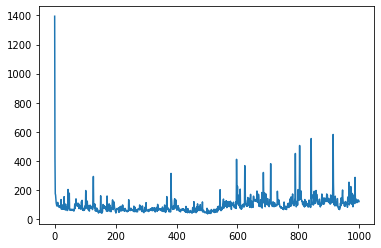

In [923]:
plt.plot(loss_hist)

### Test

In [911]:
pred = test_loop(md0, test_x, test_y, loss_fn)

loss: 146.826920 



In [922]:
pred.numpy().shape

(504, 1)

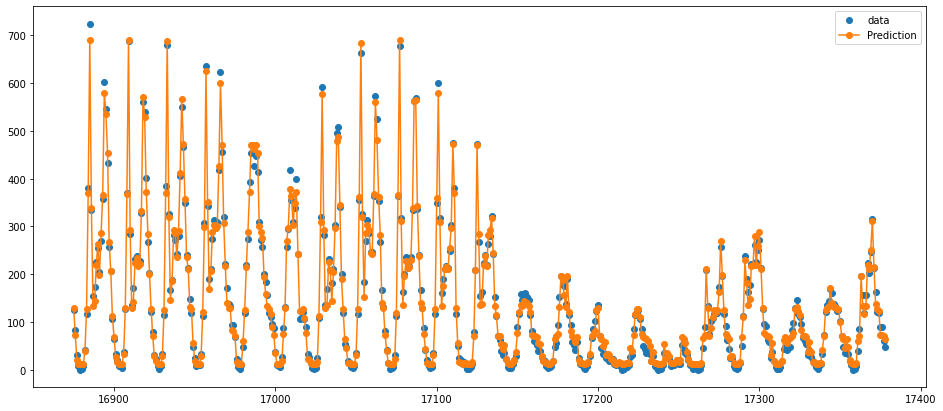

In [919]:
plt.figure(figsize = (16, 7))
x_data = df_inp_test.reset_index()['index']
pred_data = pred.numpy()
tgt_data = test_y.numpy()
cnt_plot, = plt.plot(x_data, tgt_data, 'o')
pred_plot, = plt.plot(x_data, pred_data, 'o-')
plt.legend([cnt_plot, pred_plot],['data', 'Prediction'])
plt.show()

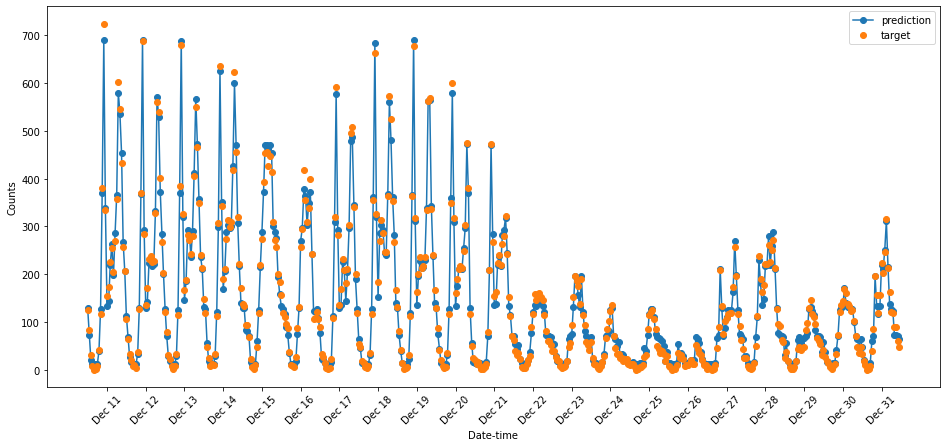

In [934]:
fig, ax = plt.subplots(figsize = (16, 7))


x_data = df_inp_test.reset_index()['index']
pred_data = pred.numpy()
tgt_data = test_y.numpy()

ax.plot(pred_data, 'o-', label='prediction')
ax.plot(tgt_data, 'o', label='target')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')

dates = pd.to_datetime(df1.loc[df_inp_test.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [924]:
df_inp_test.index

RangeIndex(start=16875, stop=17379, step=1)

已經測試過，經過no_grad的model，要重新require_grad ?

In [827]:
tmp_a = torch.tensor([0,1,2])

In [828]:
tmp_a

tensor([0, 1, 2])

In [829]:
tmp_a.shape

torch.Size([3])

In [830]:
tmpa = tmp_a.reshape([3,1])

In [831]:
tmp_a.shape

torch.Size([3])

In [832]:
tmp_a

tensor([0, 1, 2])

In [833]:
tmp_b = torch.tensor([[0],[1],[2]])

In [834]:
tmp_b

tensor([[0],
        [1],
        [2]])

In [835]:
tmp_b.shape

torch.Size([3, 1])